# Abstract

This notebook reproduces the Langevian sampling on CIFAR10 dataset

Source of pretrained DCGAN: https://github.com/csinva/gan-vae-pretrained-pytorch/tree/master/cifar10_dcgan

In [1]:
import os

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.parallel
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('...')

from cifar10_data.dcgan import Generator, Discriminator

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [4]:
model_gen = Generator()
model_gen.load_state_dict(torch.load('cifar10_data/netG_epoch_199.pth', map_location=device)) 
model_gen.to(device).eval()

model_disc = Discriminator()
model_disc.load_state_dict(torch.load('cifar10_data/netD_epoch_199.pth', map_location=device))
model_disc.to(device).eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)

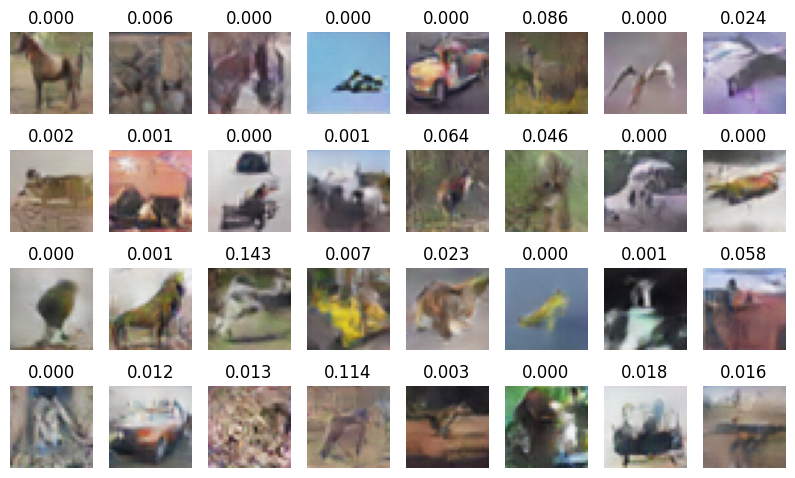

In [6]:
batch_size=32
n_dims = 100

plt.figure(figsize=[10,12])
noize=torch.randn(batch_size, n_dims, 1, 1)

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

In [22]:
def langevin_sampling(N, z_dim, generator, discriminator, device, eps=1e-3):
    eps = torch.tensor([eps]).to(device)
    # Create normal distribution
    loc = torch.zeros(z_dim).to(device)
    scale = torch.ones(z_dim).to(device)
    normal = Normal(loc, scale)
    # Making it independent
    diagn = Independent(normal, 1)
    # init noise
    z = diagn.sample()
    # Begin iterations
    for i in range(N):
        z.requires_grad = True
        n = normal.sample()
        # compute energy function
        log_p = diagn.log_prob(z)
        d = discriminator(generator(z.view(1, z.shape[0], 1, 1)))
        d = torch.log(d / (1 - d))
        energy = -log_p - d
        # gradient
        energy.backward()
        # get new point
        with torch.no_grad():
            z = z - eps / 2 * z.grad + torch.sqrt(eps) * n
    return z

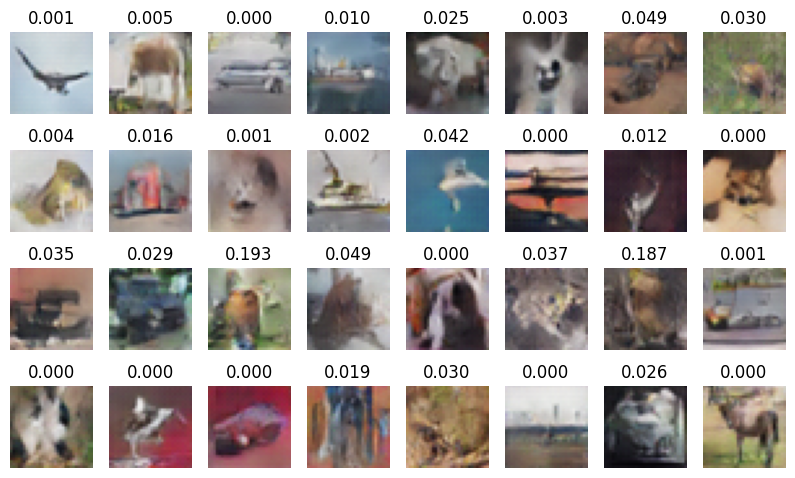

In [24]:
batch_size=32
n_dims = 100

N = 10
eps=1e-3

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))[:, :, None, None]

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

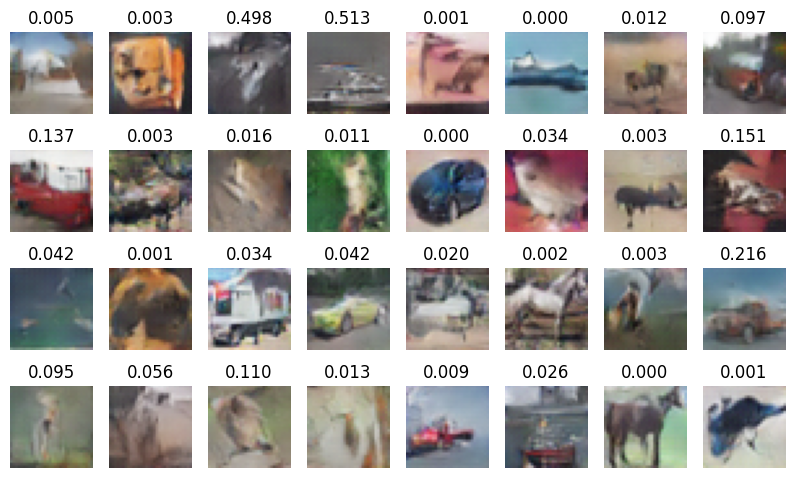

In [25]:
batch_size=32
n_dims = 100

N = 10
eps=1e-5

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))[:, :, None, None]

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

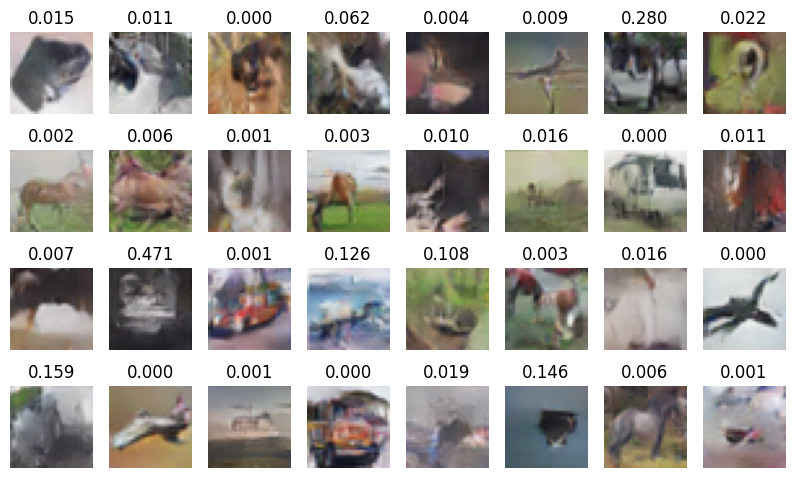

In [26]:
batch_size=32
n_dims = 100

N = 10
eps=1e-7

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))[:, :, None, None]

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())